In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

We apply our models to the input-output data of Germany. The data
we use for initial output and final consumption per industry, as well as the supply and
demand shock data is taken from:

Pichler, A. and Farmer, J. D. (2021b). Simultaneous supply and demand constraints in
input–output networks: the case of covid-19 in Germany, Italy and Spain (Version V1).
Zenodo. https://doi.org/10.5281/zenodo.4326815

## Final consumption

In [2]:
fdata = pd.read_csv('fdata_ita.csv', sep = ',')
fdata.head()

,Unnamed: 0,f,fmin,fmax,f.maxF,f.maxX
0,A01,23713.831192,0,21345.327192,2.134533e+04,21345.327192
1,A02,1287.390162,0,1238.167593,7.089618e-11,0.000000
2,A03,1144.893223,0,1030.403900,1.030404e+03,1030.403900
3,B,9853.060356,0,8868.240274,6.504931e+03,6504.930858
4,C10-C12,94671.008208,0,85212.776296,3.342065e+04,33420.652971


In [3]:
f_0 = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))
f_max

array([ 21345.32719211,   1238.16759285,   1030.40390033,   8868.24027357,
        85212.77629582,  60791.38992698,   5437.2321187 ,   9957.78516931,
         1482.8481238 ,  28895.98489511,  32622.34200513,  25499.44075049,
        20278.60926961,  14906.03494011,  28870.12365262,  34342.49803353,
        18541.51847976,  28509.42736492,  98424.78923318,  45184.76846922,
        21106.75604247,  28987.69078586,  12537.75811763,  25233.80172673,
         6541.93938938,  14035.2043312 , 158553.62259285,  29094.24731363,
        97764.14825951, 120515.42111593,  18575.33080565,   5969.91198419,
         4355.76395216,  16737.10385329,   1405.98904863,  23143.43764853,
         7002.87778518,   7671.83432483,  26815.69997904,  23698.8797476 ,
        21883.44445655,  22572.67362535,   3103.52590802, 227300.51570712,
         9556.55853069,   3375.77452237,  12530.03343449,   1075.65946079,
         6346.06246923,  25101.52588444, 167172.80168897,  91392.89105606,
       176260.5903702 ,  

In [4]:
demand_shock = np.zeros(f_max.shape[0])
for i in range (0,f_max.shape[0]):
    demand_shock[i] = round(1- f_max[i]/f_0[i],3)
    
print(demand_shock) # ok 

[ 0.1    0.038  0.1    0.1    0.1    0.1    0.099  0.1    0.1    0.1
  0.1    0.098  0.1    0.1    0.1    0.1    0.1    0.1    0.1    0.1
  0.1    0.1    0.1    0.012  0.006  0.017  0.099  0.1    0.099  0.098
  0.552  0.473  0.473  0.335  0.034  0.791  0.04   0.035  0.03   0.085
  0.016  0.011  0.049  0.005  0.052  0.084  0.098  0.092  0.05   0.049
  0.     0.     0.001  0.047 -0.   ]


## Total output

In [5]:
xdata =  pd.read_csv('xdata_ita.csv', sep = ',')
xdata.tail()   

,Unnamed: 0,x,xmin,xmax,x.maxF,x.maxX
50,O84,171897.13915,0,171897.139150,170288.802062,170288.802062
51,P85,97595.19695,0,97595.196950,95851.256718,95851.256718
52,Q,197915.54595,0,197915.545950,196575.393859,196575.393859
53,R_S,110531.33285,0,56128.781726,56128.781726,56128.781726
54,T,25597.80370,0,25597.803700,25597.803700,25597.803700


In [2]:
x_0 = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

NameError: name 'xdata' is not defined

In [7]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x_0[i],6)
    

[0.       0.849999 0.       0.345146 0.259635 0.593935 0.60647  0.48664
 0.       0.       0.082258 0.       0.472389 0.61387  0.726353 0.662572
 0.387682 0.504511 0.469949 0.696668 0.597033 0.580317 0.339612 0.
 0.       0.       0.49612  0.13656  0.334664 0.251624 0.       0.
 0.       0.       0.       0.56561  0.       0.       0.       0.
 0.       0.       0.       0.512768 0.       0.       0.       0.396788
 0.       0.416264 0.       0.       0.       0.492191 0.      ]


# IO table 

In [10]:
df = pd.read_csv('ita_wiot.csv',sep = ',',low_memory=False)
df.head()

,Unnamed: 0,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,...,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S,T
0,A01,0.097939,0.000113,0.001136,0.000567,0.181394,0.007495,0.002370,0.002256,8.609811e-04,...,0.000240,2.329589e-03,0.000298,5.629345e-04,0.005179,0.000612,0.000347,5.671440e-04,0.001305,0
1,A02,0.000000,0.006829,0.000425,0.000012,0.001058,0.000002,0.007682,0.002543,1.702069e-04,...,0.000034,9.502826e-07,0.000081,3.402062e-05,0.000777,0.000000,0.000000,4.429787e-08,0.000175,0
2,A03,0.000000,0.000031,0.011247,0.000000,0.000476,0.000003,0.000000,0.000000,7.126055e-07,...,0.000003,5.729112e-06,0.000006,7.411210e-07,0.000012,0.000054,0.000061,8.677816e-05,0.000281,0
3,B,0.000122,0.000017,0.000103,0.001477,0.000432,0.000359,0.000326,0.000678,5.043343e-04,...,0.001273,1.384237e-03,0.001033,8.018579e-04,0.000879,0.000136,0.000258,4.759545e-04,0.000395,0
4,C10-C12,0.073600,0.000149,0.043837,0.001451,0.225659,0.010460,0.000780,0.003053,8.387346e-04,...,0.001015,1.784083e-03,0.002589,1.158860e-03,0.001811,0.000382,0.000445,2.781864e-03,0.003419,0


In [11]:
df = df.iloc[0:55,1:56]
df = df.astype('float')
df.tail()

,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,C19,...,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S,T
50,0.000025,0.000178,0.000020,0.000389,0.001306,0.000464,0.000205,0.000599,0.000746,0.002112,...,0.002957,0.000262,0.000520,0.006935,0.000976,0.001562,0.001498,0.000937,0.002074,0.0
51,0.000004,0.009232,0.000015,0.000782,0.000480,0.000450,0.000488,0.000550,0.001064,0.000121,...,0.001336,0.001663,0.000638,0.000976,0.003069,0.006157,0.003212,0.003295,0.005415,0.0
52,0.000070,0.001274,0.000212,0.000490,0.000295,0.000294,0.000490,0.000149,0.000321,0.000210,...,0.000313,0.001679,0.000685,0.005008,0.000964,0.006765,0.003641,0.089797,0.001266,0.0
53,0.004346,0.000850,0.002027,0.004139,0.007808,0.006823,0.003455,0.002957,0.006526,0.004521,...,0.003979,0.005980,0.001394,0.011479,0.009689,0.004332,0.001413,0.009169,0.118812,0.0
54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


**Creating matrix A**

In [12]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

In [13]:
x_0 = np.array(x_0)

In [14]:
f_0 = np.array(f_0)

# Leontief Model

**Calculating equilibrium when x is given**

In [15]:
final_consumption = np.matmul(np.identity(N)-A, x_0)
sum(f_max)/sum(final_consumption)

0.8905066210075246

**Computing equilibrium when f is given**

In [16]:
L = np.linalg.inv(np.identity(N)-A)

In [17]:
total_output = np.matmul(L, f_0)
sum(x_max)/sum(x_0)
#sum(x_max)/sum(total_output)

0.7256416370029234

In [18]:
direct_shock = (sum(x_max)/sum(total_output),sum(f_max)/sum(final_consumption))
direct_shock

(0.7256416370029266, 0.8905066210075246)

# Optimalization

### Feasible Market Allocations
Given exogenous constraints to supply and demand, what is the feasible market allocation that maximizes final consumption and/or total output? The solution needs to lie within exogenous bounds on supply and demand and also needs to satisfy the assumption of Leontief production:

$$ x = Ax + f = Lf $$

We seek market allocations {$x^*$ , $f^*$} that (a) respect the given production recipes $x^*=Lf^*$ and (b) satisfy basic output and demand constraints $x^* \in [0, x^{max}]$ and $f^* \in [0, f^{max}]$.

**Optimization procedure**

As a first case, we determine the market allocation that maximizes gross output under the assumptions specified. Large levels of output indicate high levels of ecomomic activity, which in turn entail high levels of primary factors such as labor compensation. As a second case, we look at market allocations that maximize final comsumption given current production capacities. Due to the linearity of the Leontief framework, the problem boils down to linear programming exercises.

*Maximizing gross output*
$$ \text{max}_f \qquad 1^T(I-A)^{-1}f $$
$$ \text{Subject to} \quad (I-A)^{-1}f \in [0, x^{max}] $$

*Maximizing final consumption*
$$ \text{max}_x \qquad 1^T(I-A)x $$
$$ \text{Subject to} \quad (I-A)x \in [0, f^{max}] $$

### Maximizing total output

In [20]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return result.success, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [21]:
result = max_output(N,L,A,x_max,f_max)
result[0]
Max_output = (result[1], result[2])
Max_output

(0.6133400575407387, 0.6399275423015803)

In [22]:
z = np.ones(N)
np.matmul(np.matmul(np.matrix.transpose(z), L), f_max)/sum(x_0)

0.881162794048229

### Maximizing final consumption

In [23]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

In [24]:
result2 = max_consumption(N,L,A,x_max,f_max)
Max_consumption = (result2[1], result2[2])
Max_consumption

(0.6133407028249319, 0.6399275423015828)

**Note that both optimization problems give almost the same solution**

# Rationing

We leave out industry T:

In [25]:
f_max = f_max[:54]
x_max = x_max[:54]
A = A[:54,:54]
N = 54
x_0 = x_0[:54]
f_0 = f_0[:54]
L = np.linalg.inv(np.identity(N)-A)

### Input bottlenecks and rationing variations
In contrast to the optimization methods, this represents a bottom-up approach for finding feasible market allocations. Industries place orders to their suppliers based on incoming demand. Since suppliers can be output constrained, they might not be able to satisfy demand fully. A supplier therefore needs to make a decision about how much of each customer’s demand it serves. Intermediate consumers transform inputs to outputs based on fixed production recipes. Thus if a customer receives less inputs than she asked for, she faces an input bottleneck further constraining her production. As a consequence, the customer reduces her demand for other inputs as they are not further needed under limited productive capacities. We iterate this procedure forward until the algorithm converges.

**Strict Proportional Rationing**

If industries are unable to satisfy total incoming demand completely, they distribute output proportional to their customers’ demand, where no distinction is made between intermediate and final customers. We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand goven their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{d_i[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [26]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
     
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t==TT:
            print("Algorithm did not converge")
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [27]:
result_proportional = algo_proportional(A, L, f_max, x_max, 30, prioritize="no")
result_proportional

(0.16225463865054215, 0.1687630239228383, 6)

## Mixed priority/proportional rationing

We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand given their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{\sum_{j}A_{ij}d_j[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [28]:
def algo_mixed(A, L, fmax, xmax, TT, prioritize="yes"):
    x = [0]
    
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/np.matmul(A[i],d[t])
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
        if t == TT:
            print("Algoritm did not converge")
        
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [29]:
result_mixed = algo_mixed(A, L, f_max, x_max, 30, prioritize="yes")
result_mixed

(0.4326791328395896, 0.4412252521612323, 3)

## Priority rationing

Largest first rationing; firms are prioritized over the final consumer. Take
an initial demand vector $f[0] = f$
max as given, implying an initial aggregate demand vector
$d[1] = Lf[0]$. Every firm $i$ ranks each customers based on initial demand size. Let  $h_{ij}$ be the $j$ largest customers of firm $i$: $h_{ij} =
\{k(1), k(2), ..., k(j)
: A_{ik(1)}d_{k(1)} [1] ≥ A_{ik(2)}d_{k(2)} [1] ≥ ... ≥ A_{ik(j)}
d_{k(j)}[1] \}$. By looping over the
index $t = {1, 2, ...}$, the following system is iterated forward:

Formulas:

$$ r_{ij}[t] = \frac{x_i^{\text{max}}}{\sum_{n\in h_{ij}}A_{ih(j)}d_{n_{(j)}}[t]} $$

$$ s_i[t] = min_j \{r_{ji}[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

In [30]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []   # list we will sort
    list_2 = []   # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])     # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)         # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i.  
                for l in range(A.shape[0]):   
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [31]:
def algo_priority(A, L, fmax, xmax, ordered, TT,  prioritize="yes"):               
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
                
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            
       
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [32]:
names_ordered = order(A,L,f_max)
result_priority = algo_priority(A, L, f_max, x_max, names_ordered, 30, prioritize="yes")
result_priority

(0.0, 0.0, 3)

## Random rationing

Suppliers rank their customers randomly. The computations for this algorithm are the same as for
the priority rationing method. The only difference is the ranking $h_{ij}$ of the customers of
each industry $i$, which is now randomly taken. We implement the rationing algorithm
by taking the average from $100$ samples.

In [34]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    x = []
    y = []
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N) # We take the indices of the j+1 ( with j from 0 to N-1) biggest suppliers  
                random_ordered[i].append(random)

        result = algo_priority(A, L, fmax, xmax, random_ordered, 25, prioritize="yes")
        result_x = result[0]
        result_y = result[1]
        t = result[2]
        
        x.append(result_x)
        y.append(result_y)
        
    result_random = (sum(x)/len(x), sum(y)/len(y), t)
    return result_random

In [35]:
result_random = algo_random(A, L, f_max, x_max, 100, prioritize = "random")
result_random

(0.04136119690101073, 0.04266306666657028, 3)

### Summary of all the impact predicitions:

In [36]:
print("Optimalization: (x,f)")
print("------------------------")
print(Max_output)
print(Max_consumption)
print("------------------------")
print("Direct Shocks: (x, f)")
print("------------------------")
print(direct_shock)
print("------------------------")
print("Rationing Methods: (x,f)")
print("------------------------")
print(result_proportional)
print(result_mixed)
print(result_priority)
print(result_random)

Optimalization: (x,f)
------------------------
(0.6133400575407387, 0.6399275423015803)
(0.6133407028249319, 0.6399275423015828)
------------------------
Direct Shocks: (x, f)
------------------------
(0.7256416370029266, 0.8905066210075246)
------------------------
Rationing Methods: (x,f)
------------------------
(0.16225463865054215, 0.1687630239228383, 6)
(0.4326791328395896, 0.4412252521612323, 3)
(0.0, 0.0, 3)
(0.04136119690101073, 0.04266306666657028, 3)


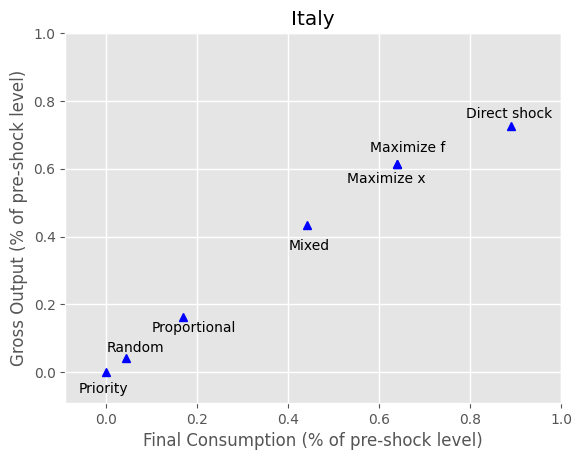

In [37]:
plt.style.use('ggplot')
plt.title("Italy")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(result_proportional[1], result_proportional[0], 'b^')
plt.plot(result_mixed[1], result_mixed[0], 'b^')
plt.plot(result_priority[1], result_priority[0], 'b^')
plt.plot(result_random[1], result_random[0], 'b^')
plt.plot(Max_consumption[1], Max_consumption[0], 'b^')
plt.plot(Max_output[1], Max_output[0], 'b^')
plt.plot(direct_shock[1], direct_shock[0], 'b^')

#x = np.linspace(-0.09,1.1)
#y = x
#plt.plot(x,y, 'k--', linewidth =0.5)

plt.text(0.1,0.12,'Proportional')
plt.text(0.4,0.36,'Mixed')
plt.text(0.0,0.06,'Random')
plt.text(-0.06,-0.06,'Priority')
plt.text(0.58,0.65, 'Maximize f')
plt.text(0.53,0.56, 'Maximize x')
plt.text(0.79,0.75, 'Direct shock')

plt.xlim(-0.09,1) 
plt.ylim(-0.09,1)

plt.xlabel("Final Consumption (% of pre-shock level)")
plt.ylabel("Gross Output (% of pre-shock level)")
plt.savefig('plot_Italy.png')
plt.show()

# Shock Magnitude Effect

We now investigate how these results depend on the magnitude of the initial shocks. We follow
the approach of Pichler and Farmer, who have done this by rescaling supply and demand shocks and then applying the optimization methods and the rationing algorithms to the new shock data. By doing this for various shocks scales, we can investigate how the
impact predictions change in function of the shock scale. We use different scaling factors for demand and supply constraints:

$$ x^{max}_i = (1-\alpha^S\varepsilon_i^S)x_{i,0}$$

$$ f^{max}_i = (1-\alpha^D\varepsilon_i^D)f_{i,0}$$

Where $\alpha^S$ and $\alpha^D$ lie between $0$ and $1$. 

In [38]:
def shockscale(x, xmax, f, fmax, scale_x, scale_f):
    ss_full = np.divide(xmax,x)-1
    ds_full = np.divide(fmax,f)-1
    
    ss = ss_full*scale_x
    
    x_shocked = np.zeros(N)
    
    for i in range (0,N):
        x_shocked[i] = (np.ones(N)+ ss)[i]*x[i]

    
    ds = ds_full*scale_f
    f_shocked = np.zeros(N)
    
    for i in range (0,N):
        f_shocked[i] = (np.ones(N)+ ds)[i]*f[i]
    
    return x_shocked, f_shocked

### Direct shock

In [39]:
def scale_run_direct_shock(scalewhat = "both", seq = np.linspace(0,1,100)):    
    res_dir_x = []
    res_dir_f = []
    for i in range(0, len(seq)):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=0, scale_f=seq[i])
            
    
        res_dir_x.append(sum(scaleres[0])/sum(x_0))
        res_dir_f.append(sum(scaleres[1])/sum(f_0)) 
    dataframe = {'x': res_dir_x,
                 'f': res_dir_f,
                'Scale': scalewhat, 'Algorithm': 'Direct_shock', 'a': seq}
    df = pd.DataFrame(dataframe)
        
    return df

### Optimization

In [40]:
def scale_run_optimizationX(scalewhat = "both", runs = 100, seq = np.linspace(0,1,100)):
    resmax_output_x = []
    resmax_output_f = []
    
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=0, scale_f=seq[i])
        
        #print(scaleres[0])
        resmaxX = max_output(N , L, A, xmax = scaleres[0], fmax=scaleres[1])
        #print(resmaxX)
        if resmaxX[0] == True:
        #print(resmaxX)
            resmax_output_x.append(resmaxX[1])
            resmax_output_f.append(resmaxX[2])
        else: 
            resmax_output_x.append('NaN')
            resmax_output_f.append('NaN')
            
            
        i = i+1
        
        
    dataframe = {'x': resmax_output_x,
                 'f': resmax_output_f,
                'Scale': scalewhat, 'Algorithm': 'Max_output', 'a': seq}
    df = pd.DataFrame(dataframe)
    
    return df

In [41]:
x_direct_D = scale_run_direct_shock(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,0].tolist()
a_direct_D = scale_run_direct_shock(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,4].tolist()

x_opt_D = scale_run_optimizationX(scalewhat = "demand", runs = 100, seq = np.linspace(0,1,100)).iloc[:,0].tolist()
a_opt_D = scale_run_optimizationX(scalewhat = "demand", runs = 100, seq = np.linspace(0,1,100)).iloc[:,4].tolist()

### Rationing 

In [42]:
TT = 25

In [43]:
def scale_run_rationing(scalewhat = "both",  seq = np.linspace(0,1,100)):
    res1x = []
    res1f = []
    
    res2x = []
    res2f = []
    
    res3x = []
    res3f = []
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=0, scale_f=seq[i])
        
        res1 = algo_proportional(A, L, scaleres[1], scaleres[0], TT, prioritize = "no")
        res2 = algo_mixed(A, L, scaleres[1], scaleres[0],TT, prioritize="yes")
        names_ordered = order(A,L,scaleres[1])
        res3 = algo_priority(A, L, scaleres[1], scaleres[0], names_ordered,TT, prioritize="yes")
        
        if res1[2] != 100:
            res1x.append(res1[0])
            res1f.append(res1[1])
        else:
            res1x.append('NaN')
            res1f.append('NaN')
        
        if res2[2] != 100:
            res2x.append(res2[0])
            res2f.append(res2[1])
        else:
            res2x.append('NaN')
            res2f.append('NaN')
            
        if res3[2] != 100:
            res3x.append(res3[0])
            res3f.append(res3[1])
        else:
            res3x.append('NaN')
            res3f.append('NaN')
        
        i= i+1
    
    dataframe1 = {'x': res1x, 'f': res1f, 'Scale': scalewhat, 'Algorithm': 'Proportional', 'a': seq }
    df1 = pd.DataFrame(dataframe1)
    
    dataframe2 = {'x': res2x, 'f': res2f, 'Scale': scalewhat, 'Algorithm': 'Mixed', 'a': seq }
    df2 = pd.DataFrame(dataframe2)
    
    dataframe3 = {'x': res3x, 'f': res3f, 'Scale': scalewhat, 'Algorithm': 'Priority', 'a': seq }  
    df3 = pd.DataFrame(dataframe3)
    
    return df1, df2, df3

In [44]:
def scale_run_random_rationing(scalewhat = "both", seq = np.linspace(0,1,100)):
    res4x = []
    res4f = []
    i=0
    while i < len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=0, scale_f=seq[i])
        
           
        res4 = algo_random(A, L, scaleres[1], scaleres[0], 50, prioritize = "random")
        
        if res4[2] != 100:
            res4x.append(res4[0])
            res4f.append(res4[1]) 
        else:
            res4x.append('NaN')
            res4f.append('NaN') 
        
        i = i+1
    
    dataframe4 = {'x': res4x, 'f': res4f, 'Scale': scalewhat, 'Algorithm': 'Random', 'a': seq}  
    df4 = pd.DataFrame(dataframe4)
    
    return df4

# Results

## No supply shocks

We first investigate the impact of the demand shock magnitude on the economic impact
predictions. To do this, we set $\alpha^S = 0$ and we let $\alpha^D$ range between 0 and 1. For 100
different values of $\alpha^D$, we apply the optimization methods and the rationing algorithms
to the new shock data.

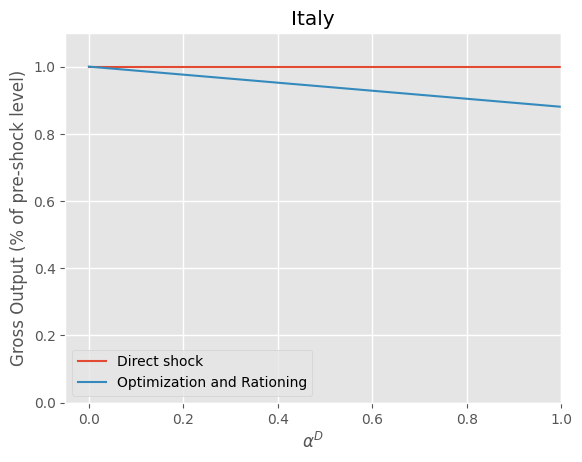

In [45]:
plt.style.use('ggplot')
plt.title("Italy")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)
plt.plot(a_direct_D, x_direct_D)
plt.plot(a_opt_D, x_opt_D)
plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)

#plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\alpha^D$')
plt.ylabel("Gross Output (% of pre-shock level)")
plt.legend(['Direct shock', 'Optimization and Rationing'])
plt.savefig('plot_ita_scale_demand.png')

## No demand shocks

We now look at what happens if we only rescale the supply shock and set $\alpha^D = 0$.

In [46]:
result_direct = scale_run_direct_shock(scalewhat = "supply",  seq = np.linspace(0,1,100))
x_direct = np.array(result_direct.iloc[:,0].astype('float'))
a_direct = np.array(result_direct.iloc[:,4].astype('float'))

result_opt = scale_run_optimizationX(scalewhat = "supply", runs = 100, seq = np.linspace(0,1,100))
x_opt= np.array(result_opt.iloc[:,0].astype('float'))
a_opt = np.array(result_opt.iloc[:,4].astype('float'))


result_prop = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[0]
x_prop = np.array(result_prop.iloc[:,0].astype('float'))
a_prop = np.array(result_prop.iloc[:,4].astype('float'))

result_mixed = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[1]
x_mixed = np.array(result_mixed.iloc[:,0].astype('float'))
a_mixed = np.array(result_mixed.iloc[:,4].astype('float'))

result_priority = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[2]
x_priority = np.array(result_priority.iloc[:,0].astype('float'))
a_priority = np.array(result_priority.iloc[:,4].astype('float'))

In [47]:
result_random = scale_run_random_rationing(scalewhat = "supply", seq = np.linspace(0,1,100))
x_random = np.array(result_random.iloc[:,0].astype('float'))
a_random = np.array(result_random.iloc[:,4].astype('float'))

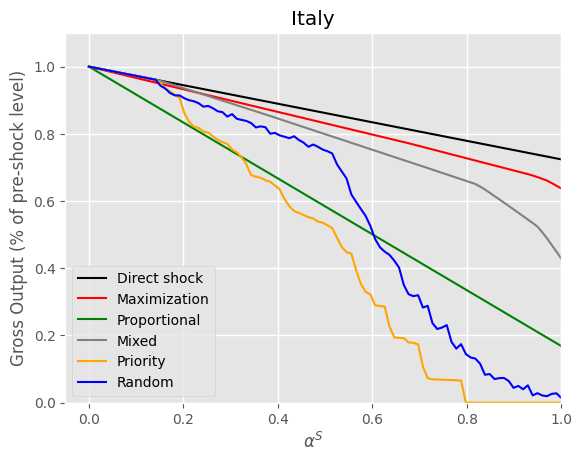

In [48]:
plt.style.use('ggplot')
plt.title("Italy")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(a_direct, x_direct, 'black')
plt.plot(a_opt, x_opt, 'red')
plt.plot(a_prop, x_prop, 'green')
plt.plot(a_mixed, x_mixed, 'grey')
plt.plot(a_priority, x_priority, 'orange')
plt.plot(a_random, x_random, 'blue')

plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)
#plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\alpha^S$')
plt.ylabel("Gross Output (% of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'Random'])
plt.savefig('plot_ita_scale_february.png')

In [49]:
#result_direct = scale_run_direct_shock(scalewhat = "supply",  seq = np.linspace(0,1,100)) #ok: zelfde resultaat
f_direct = np.array(result_direct.iloc[:,1].astype('float'))
a_direct = np.array(result_direct.iloc[:,4].astype('float'))

#result_opt = scale_run_optimizationX(scalewhat = "supply", runs = 100, seq = np.linspace(0,1,100)) #ok 
f_opt= np.array(result_opt.iloc[:,1].astype('float'))
a_opt = np.array(result_opt.iloc[:,4].astype('float'))


#result_prop = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[0] #ok: zelfde resultaat
f_prop = np.array(result_prop.iloc[:,1].astype('float'))
a_prop = np.array(result_prop.iloc[:,4].astype('float'))

#result_mixed = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[1] #ok: zelfde resultaat
f_mixed = np.array(result_mixed.iloc[:,1].astype('float'))
a_mixed = np.array(result_mixed.iloc[:,4].astype('float'))

#result_priority = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[2]
f_priority = np.array(result_priority.iloc[:,1].astype('float'))
a_priority = np.array(result_priority.iloc[:,4].astype('float'))

f_random = np.array(result_random.iloc[:,1].astype('float'))
a_random = np.array(result_random.iloc[:,4].astype('float'))

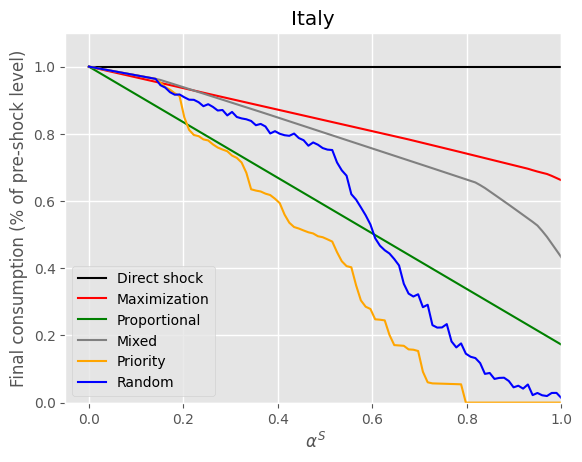

In [50]:
plt.style.use('ggplot')
plt.title("Italy")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(a_direct, f_direct, 'black')
plt.plot(a_opt, f_opt, 'red')
plt.plot(a_prop, f_prop, 'green')
plt.plot(a_mixed, f_mixed, 'grey')
plt.plot(a_priority, f_priority, 'orange')
plt.plot(a_random, f_random, 'blue')

plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)
#plt.rcParams['text.usetex'] = True
plt.xlabel(r' $\alpha^S$')
plt.ylabel("Final consumption (% of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'Random'])
plt.savefig('plot_ita_scale_f.png')